# Deliverable D4.10
## Evaluation report on the second prototype tool for the automatic semantic description of music samples

### Key estimation results

In [1]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
from collections import defaultdict
seaborn.set(style="whitegrid")
%matplotlib inline
dataset_dirnames = ['giantsteps-key-dataset', 'apple_loops_db', 'mixcraft_loops_db']
datasets = load_datasets(dirnames=dataset_dirnames, clean=True, exclude_files=['analysis_freesound_extractor_04.json'])  # Load and clean datasets
methods_to_compare = ['ACExtractorV1', 'ACExtractorV2', 'EdmkeyShaath', 'EdmkeyKrumhansl', 'EdmkeyTemperley', 'QMULKeyDetector']
accuracy_functions = [mireval_key_same, mireval_key_fifth, mireval_key_relative, mireval_key_parallel, mireval_key_weighted_score]
accuracy_functions_names = ['Same', 'Fifth', 'Relative', 'Parallel', 'Mirex']

DISPLAY_NAMES = {
'EdmkeyShaath': 'EDMKey1',
'EdmkeyKrumhansl': 'EDMKey2',
'EdmkeyTemperley': 'EDMKey3',
'ACExtractorV1': 'ACExtractorV1',
'ACExtractorV2': 'ACExtractorV2',
'QMULKeyDetector': 'QMULKey',
}

In [2]:
new_datasets = []
for count, dataset in enumerate(datasets):
    try:
        with open('dataset_curation_{0}.txt'.format(dataset.short_name), 'r') as fid:
            sids_response = {}
            for line in fid.readlines():
                sid, response_raw = line.split(' - ')
                if 'YES' in response_raw:
                    sids_response[sid] = True
                else:
                    sids_response[sid] = False                
        allowed_dataset_ids = [key for key, value in sids_response.items() if value == True]
        filtered_dataset = dataset.filter_data(condition=lambda x, y, z: x in allowed_dataset_ids)
        filtered_dataset.short_name = dataset.short_name + '-rel'
        filtered_dataset.name = dataset.name + ' - Reliable'
        new_datasets.append(dataset)
        new_datasets.append(filtered_dataset)     
    except FileNotFoundError:
        new_datasets.append(dataset)
        
datasets= new_datasets


Basic statistics per dataset
----------------------------

Dataset    N      T. Duration   Mean Duration   Durations range    
-------------------------------------------------------------------
GSKY       604    20h 4m        119.61s         44.70s - 120.01s   
APPL       2743   6h 15m        8.21s           2.07s - 40.05s     
APPL-rel   99     0h 13m        8.14s           2.72s - 23.48s     
MIXL       2502   8h 23m        12.08s          0.86s - 82.29s     
MIXL-rel   101    0h 17m        10.60s          1.81s - 44.65s     


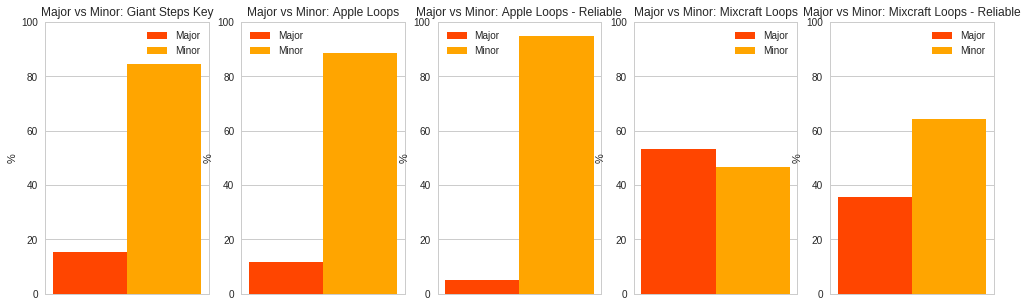

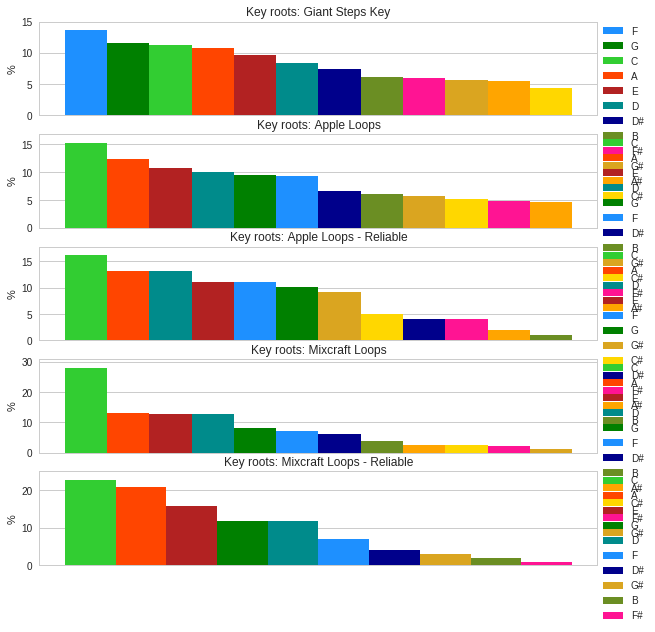

In [3]:
table_header = ['Dataset', 'N', 'T. Duration', 'Mean Duration', 'Durations range']
table_rows = list()
genres = dict()

for dataset in datasets:
    row = [dataset.short_name]
    row.append(len(dataset.data))
    durations = dataset.get_data('analysis.durations.duration')
    if durations:
        durations = np.array(durations)
        row.append('%ih %im' % (int(durations.sum()) / 3600, int(durations.sum() % 3600) / 60))
        row.append('%.2fs' % durations.mean())
        row.append('%.2fs - %.2fs' % (durations.min(), durations.max()))
    table_rows.append(row)

print(title('Basic statistics per dataset'))
print_table(table_header, table_rows, highlight_max=False)

# Key major/minor bars
fig1, axs = plt.subplots(1, len(datasets), figsize=(17, 5))
for count, dataset in enumerate(datasets):
    keys = dataset.get_data('annotations.key')
    total = len(keys)
    major_minor = [len([key for key in keys if 'major' in key])*100.0/total, len([key for key in keys if 'minor' in key])*100.0/total]
    ax = axs[count]
    ax.bar(1, major_minor[0], 1, color=COLORS[0], label='Major')
    ax.bar(2, major_minor[1], 1, color=COLORS[1], label='Minor')
    ax.set_ylabel('%')
    ax.set_ylim((0, 100))
    ax.set_xticks([])
    ax.set_title('Major vs Minor: %s' % dataset.name)
    ax.legend()
plt.show()


# Key root histogram
from collections import Counter
from ac_utils.music import root_to_num, num_to_root

fig1, axs = plt.subplots(len(datasets), 1, figsize=(10, 10))
for count, dataset in enumerate(datasets):
    keys = dataset.get_data('annotations.key')
    roots = [num_to_root(root_to_num(key.split(' ')[0])) for key in keys]
    roots_counts = Counter(roots).most_common()
    total = len(roots)
    ax = axs[count]
    for ind, (root, rcount) in enumerate(roots_counts):
        key_color = COLORS[root_to_num(root)]
        ax.bar(ind, rcount*100.0/total, 1, color=key_color, label=root)
    ax.set_ylabel('%')
    ax.set_ylim((0, (roots_counts[0][1]*100.0/total)*1.1))
    ax.set_xticks([])
    ax.set_title('Key roots: %s' % dataset.name)
    ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()



General key estimation results (GSKY)
**************************************


Method          Same    Fifth   Relative   Parallel   Mirex   % analysis failed   
----------------------------------------------------------------------------------
ACExtractorV2   59.44   5.46    8.94       7.78       66.41   0.00                
EDMKey1         55.46   6.46    7.62       14.07      63.79   0.00                
EDMKey2         47.85   8.77    8.77       15.40      57.95   0.00                
EDMKey3         47.35   4.14    13.74      8.11       55.17   0.00                
ACExtractorV1   34.11   2.65    8.44       7.12       39.39   0.00                
QMULKey         30.63   8.11    12.75      5.13       39.54   0.00                


General key estimation results (APPL)
**************************************


Method          Same    Fifth   Relative   Parallel   Mirex   % analysis failed   
----------------------------------------------------------------------------------
EDMKey1 

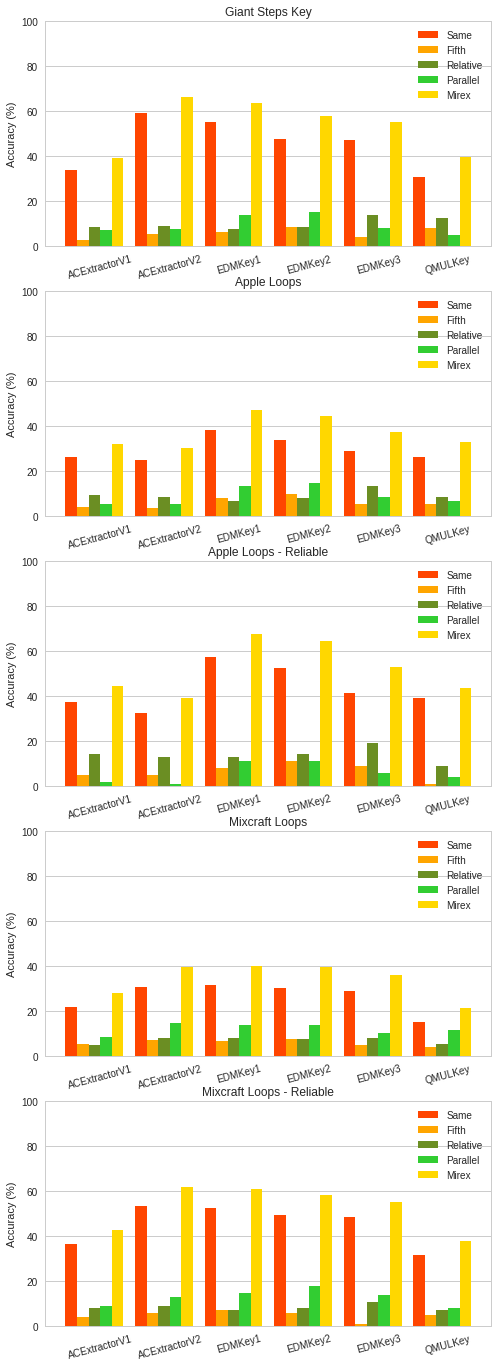

In [8]:
all_datasets_method_results = defaultdict(list)
all_datasets_method_results_stats = defaultdict(list)
fig1, axs = plt.subplots(5, 1, figsize=(8, 24))
for count, dataset in enumerate(datasets):
    print(title("\nGeneral key estimation results (%s)" % dataset.short_name, c='*'))
    table_header = ['Method'] + accuracy_functions_names + ['% analysis failed']
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = defaultdict(list)
            all_datasets_method_results_stats[method] = defaultdict(list)
        try:
            table_row = [DISPLAY_NAMES.get(method, method)]
            for accuracy_func in accuracy_functions:
                method_results = accuracy_func(dataset.data, method)
                acc_method_avg = 100 * basic_statistics(method_results)['avg']
                table_row.append(acc_method_avg)
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
                all_datasets_method_results_stats[method][accuracy_func.__name__].append(acc_method_avg)
                
            n_analysis_failed = len([item for item in dataset.data.values() if not item['analysis'].get(method, False)])
            table_row.append(100 * n_analysis_failed / len(dataset.data))

            table_rows.append(table_row)
        except IndexError as e:
            print("Warning: Skipping method %s (analsyis not found in dataset)" % method)
            continue
    print("")
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)
    
    # Plot results
    #ax = axs[count//2,count%2]
    ax = axs[count]
    N = len(methods_to_compare)
    ind = np.arange(N)
    rects = list()
    width = 1.0 / (len(accuracy_functions) + 1)
    for i in range(0, len(accuracy_functions)):
        means = [row[i+1] for row in table_rows]
        rects.append(ax.bar(ind + i * width, means, width, color=COLORS[i]))
    ax.set_title(dataset.name)
    ax.set_xticks(ind + (width * len(accuracy_functions) * 1.0)/2)
    ax.set_xticklabels([DISPLAY_NAMES.get(method, method)  for method in methods_to_compare], rotation=15)
    ax.legend([rect[0] for rect in rects], accuracy_functions_names)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)

In [9]:
print(title("General key estimation results (ALL DATASETS)"))
table_header = ['Method'] + accuracy_functions_names
table_rows = list()
for method, results in all_datasets_method_results_stats.items():
    table_row = [DISPLAY_NAMES.get(method, method) ]
    for accuracy_measure in [f.__name__ for f in accuracy_functions]:
        data = results[accuracy_measure]
        table_row.append(basic_statistics(data)['avg'])
    table_rows.append(table_row)
print_table(table_header, table_rows, sort_column=-1, highlight_max=True)



General key estimation results (ALL DATASETS)
---------------------------------------------

Method          Same    Fifth   Relative   Parallel   Mirex   
--------------------------------------------------------------
EDMKey1         47.13   7.33    8.56       13.41      56.05   
EDMKey2         42.88   8.69    9.36       14.58      52.95   
ACExtractorV2   40.17   5.42    9.55       8.31       47.41   
EDMKey3         39.02   4.97    13.10      9.36       47.31   
ACExtractorV1   31.30   4.24    8.97       6.38       37.39   
QMULKey         28.67   4.68    8.51       7.08       34.98   


In [10]:
'''
from IPython.display import display, Markdown, HTML, Audio
import pprint

ds = datasets[2]
print(title(ds.name))
for sid, sound in ds.data.items():
    if sound['analysis']['ACExtractorV2']['key'] == sound['annotations']['key'] and sound['analysis']['EdmkeyShaath']['key'] != sound['annotations']['key']:
        display(Audio(os.path.join(ds.dataset_path, sound['wav_sound_path'])))
        print('GT:', sound['annotations']['key'])
        pprint.pprint(sound['analysis']['ACExtractorV2']['key'])
        pprint.pprint(sound['analysis']['ACExtractorV2']['key_confidence'])
        pprint.pprint(sound['analysis']['EdmkeyShaath']['key'])
        print('')
'''

"\nfrom IPython.display import display, Markdown, HTML, Audio\nimport pprint\n\nds = datasets[2]\nprint(title(ds.name))\nfor sid, sound in ds.data.items():\n    if sound['analysis']['ACExtractorV2']['key'] == sound['annotations']['key'] and sound['analysis']['EdmkeyShaath']['key'] != sound['annotations']['key']:\n        display(Audio(os.path.join(ds.dataset_path, sound['wav_sound_path'])))\n        print('GT:', sound['annotations']['key'])\n        pprint.pprint(sound['analysis']['ACExtractorV2']['key'])\n        pprint.pprint(sound['analysis']['ACExtractorV2']['key_confidence'])\n        pprint.pprint(sound['analysis']['EdmkeyShaath']['key'])\n        print('')\n"

In [11]:
# Run pairwise statistical tests
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print("")
    print(title('Statistical tests for dataset %s' % dataset.short_name))
    for accuracy_func in accuracy_functions:
        print('\nMeasure: %s' % accuracy_func.__name__)
        table_header = [' '] + [DISPLAY_NAMES.get(method, method) for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    result = compute_mcnemar_test(accuracy_func(dataset.data, method_a), accuracy_func(dataset.data, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([DISPLAY_NAMES.get(method_a, method_a) ] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset GSKY
----------------------------------


Measure: mireval_key_same
                ACExtractorV1   ACExtractorV2   EDMKey1     EDMKey2     EDMKey3     QMULKey     
------------------------------------------------------------------------------------------------
ACExtractorV1   -               1.26e-25*       1.74e-19*   1.35e-09*   1.94e-10*   0.156       
ACExtractorV2   1.26e-25*       -               0.00833*    3.17e-12*   5.34e-12*   9.93e-29*   
EDMKey1         1.74e-19*       0.00833*        -           9.14e-10*   1.76e-05*   4.54e-22*   
EDMKey2         1.35e-09*       3.17e-12*       9.14e-10*   -           0.853       4.75e-12*   
EDMKey3         1.94e-10*       5.34e-12*       1.76e-05*   0.853       -           1.04e-12*   
QMULKey         0.156           9.93e-29*       4.54e-22*   4.75e-12*   1.04e-12*   -           

Measure: mireval_key_fifth
                ACExtractorV1   ACExtractorV2   EDMKey1    EDMKey2     EDMKey3     QMULKey     


/opt/conda/lib/python3.6/site-packages/statsmodels/sandbox/stats/runs.py:559: RuntimeWarning: divide by zero encountered in true_divide
  stat = (np.abs(n1 - n2) - corr)**2 / (1. * (n1 + n2))


                ACExtractorV1   ACExtractorV2   EDMKey1   EDMKey2    EDMKey3   QMULKey    
------------------------------------------------------------------------------------------
ACExtractorV1   -               0*              0.371     0.0771     0.134     0.221      
ACExtractorV2   0*              -               0.371     0.0771     0.134     0.221      
EDMKey1         0.371           0.371           -         0.248      1         0.0455     
EDMKey2         0.0771          0.0771          0.248     -          0.617     0.00937*   
EDMKey3         0.134           0.134           1         0.617      -         0.0269     
QMULKey         0.221           0.221           0.0455    0.00937*   0.0269    -          

Measure: mireval_key_relative
                ACExtractorV1   ACExtractorV2   EDMKey1   EDMKey2   EDMKey3   QMULKey   
----------------------------------------------------------------------------------------
ACExtractorV1   -               1               1         0.789

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning

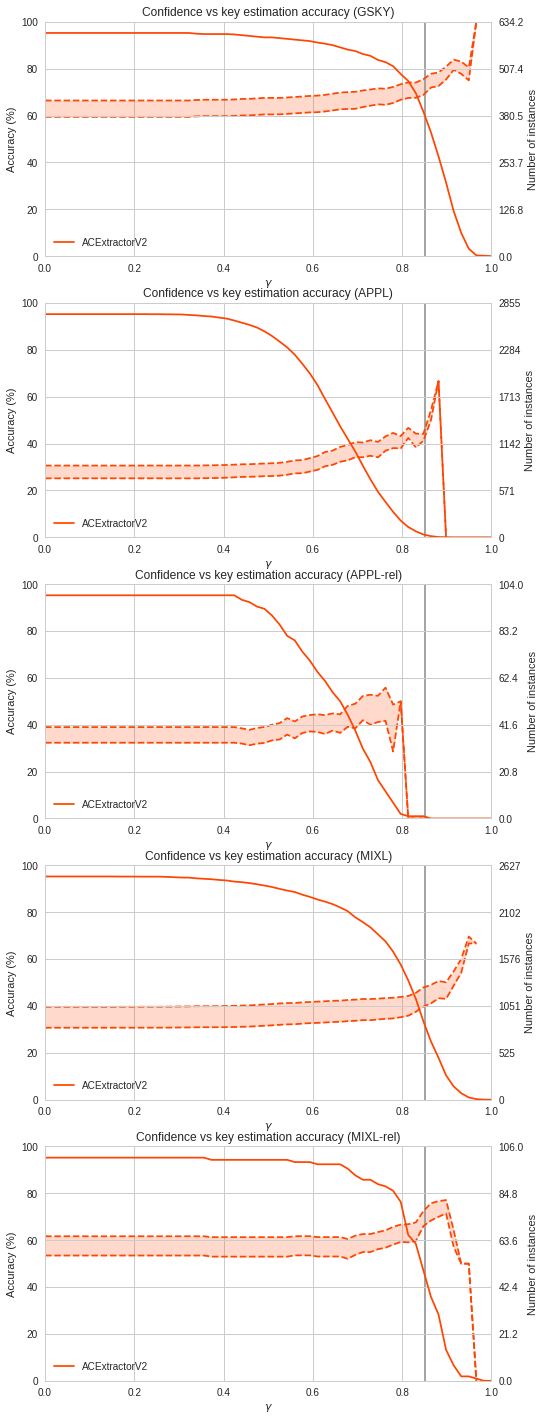

In [16]:
# Accuracy vs confidence per dataset
conf_threshold = 0.85

fig1, axs = plt.subplots(5, 1, figsize=(8, 25))
for count, dataset in enumerate(datasets):
    ax1 = axs[count]
    ax2 = ax1.twinx()
    for count, method in enumerate(['ACExtractorV2']):
        min_acc = list()
        max_acc = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            try:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'key_confidence'), conf_min)]).data                
                min_acc.append(100 * basic_statistics(mireval_key_same(filtered_data, method))['avg'])
                max_acc.append(100 * basic_statistics(mireval_key_weighted_score(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
                
        ax1.plot(steps, min_acc, color=COLORS[count], ls="--")
        ax1.plot(steps, max_acc, color=COLORS[count], ls="--")
        ax1.fill_between(steps, min_acc, max_acc, color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label=method)

    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax1.vlines(conf_threshold, 0, 100, color='#999999')
    ax1.set_xlim(0.0, 1.0)
    ax1.set_title('Confidence vs key estimation accuracy (%s)' % dataset.short_name)


In [15]:
# Accuracy for for confidence threshold > conf_threshold
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in ['ACExtractorV2']:
    table_row = list()
    table_row.append(method)
    for dataset in datasets:
        try:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'key_confidence'), conf_threshold)]).data
            min_acc = 100 * basic_statistics(mireval_key_same(filtered_data, method))['avg']
            max_acc = 100 * basic_statistics(mireval_key_weighted_score(filtered_data, method))['avg']
        except IndexError:
            print('Unable to compute results for method %s and dataset %s' % (method, dataset.short_name))
            table_row.append('-')
            continue
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)

print('Accuracy for conf threshold %0.2f' % conf_threshold)
print_table(table_header, table_rows)

Accuracy for conf threshold 0.85
Method          GSKY                      APPL                     APPL-rel               MIXL                      MIXL-rel                  
----------------------------------------------------------------------------------------------------------------------------------------------
ACExtractorV2   A=69.27 - 75.94%, N=64%   A=46.67 - 49.33%, N=1%   A=0.00 - 0.00%, N=1%   A=39.79 - 47.92%, N=34%   A=66.67 - 73.33%, N=48%   
